In [1]:
import torch
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
ckpt='results/detm_un_K_20_Htheta_800_Optim_adam_Clip_0.0_ThetaAct_relu_Lr_0.001_Bsz_512_RhoSize_300_L_3_minDF_10_trainEmbeddings_1_divReg_2_label10'
with open(ckpt, 'rb') as f:
    model = torch.load(f)


In [2]:
import data
import os
import numpy as np

data_path='scripts/data_grants_False/'
min_df=10
## get data

data_file = os.path.join(data_path, 'min_df_{}'.format(min_df)+'/labels')
vocab, train, valid, test = data.get_data(data_file, temporal=True)
print('cstatistics' in vocab)
print('c-statistics' in vocab)
vocab_size = len(vocab)


# 1. training data
print('Getting training data ...')
train_tokens = train['tokens']
train_counts = train['counts']
train_times = train['times']
num_times = len(np.unique(train_times))
num_docs_train = len(train_tokens)
train_rnn_inp = data.get_rnn_input(
    train_tokens, train_counts, train_times, num_times, vocab_size, num_docs_train)


False
False
Getting training data ...
idx: 0/396
idx: 20/396
idx: 40/396
idx: 60/396
idx: 80/396
idx: 100/396
idx: 120/396
idx: 140/396
idx: 160/396
idx: 180/396
idx: 200/396
idx: 220/396
idx: 240/396
idx: 260/396
idx: 280/396
idx: 300/396
idx: 320/396
idx: 340/396
idx: 360/396
idx: 380/396


In [3]:
emb_size=200
ind=[100]

data_batch, times_batch = data.get_batch(
            train_tokens, train_counts, ind, vocab_size, emb_size, temporal=True, times=train_times)

In [4]:
data_batch.shape,times_batch,train_times,train_counts.shape,train_tokens[0]
print(set(train_times))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35}


In [5]:
sums = data_batch.sum(1).unsqueeze(1)
normalized_bows = data_batch / sums

bsz = normalized_bows.size(0)
alpha, kl_alpha = model.get_alpha()
eta, kl_eta = model.get_eta(train_rnn_inp)
theta, kl_theta = model.get_theta(eta, normalized_bows, times_batch)

theta.shape,eta.shape

(torch.Size([1, 20]), torch.Size([36, 20]))

In [6]:
import pickle

with open ('scripts/data_grants_False/min_df_10/labels/vocab.pkl','rb') as f:
    vocab=pickle.load(f)

len(vocab)

52612

In [7]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import Stemmer

from nltk.stem import WordNetLemmatizer

y=2020

abs = pd.read_csv('../grant/RePORTER_PRJ_C_FY'+str(y)+'.csv',encoding = "ISO-8859-1", low_memory=False,on_bad_lines='skip')
prj = pd.read_csv("../grant/RePORTER_PRJABS_C_FY"+str(y)+".csv",encoding = "ISO-8859-1", low_memory=False, on_bad_lines='skip')

#abs = pd.read_csv('../grant/abstract2021.csv',encoding = "ISO-8859-1", low_memory=False,on_bad_lines='skip')
#prj = pd.read_csv("../grant/project2021.csv",encoding = "ISO-8859-1", low_memory=False, on_bad_lines='skip')

df = pd.merge(abs,prj,on='APPLICATION_ID')
df=df.dropna(subset=['ABSTRACT_TEXT','IC_NAME'])
df = df.loc[df['APPLICATION_TYPE'] ==1]
lbl_valid=[ic for ic in set(df['IC_NAME']) if list(df['IC_NAME']).count(ic)>10]
len(lbl_valid)
#df = df.loc[df['IC_NAME'].isin(['NATIONAL CANCER INSTITUTE','NATIONAL INSTITUTE OF MENTAL HEALTH'])]
df = df.loc[df['IC_NAME'].isin(lbl_valid)]
vectorizer = CountVectorizer(vocabulary=vocab)
df=df.dropna(subset=['ABSTRACT_TEXT','IC_NAME'])

matrix_np = vectorizer.fit_transform(df.ABSTRACT_TEXT)

words_df = pd.DataFrame(matrix_np.toarray(),columns=vectorizer.get_feature_names())

device='cuda'
matrix = torch.from_numpy(matrix_np.toarray()).float().to(device)
sums = matrix.sum(1).unsqueeze(1)
normalized_bows = matrix / sums
times_2020=np.array([y-1985 for i in range(len(matrix))])
times_2020 = torch.from_numpy(times_2020).to(device)

bsz = normalized_bows.size(0)
alpha, kl_alpha = model.get_alpha()
eta, kl_eta = model.get_eta(train_rnn_inp)
theta, kl_theta = model.get_theta(eta, normalized_bows, times_2020)

embed = torch.matmul(theta.cpu(), alpha.cpu()[35])

v2k=list(set(df['IC_NAME']))
k2v={k:v for v,k in enumerate(v2k)}
y=[k2v[k] for k in df['IC_NAME']]

/home/ruiyiz5/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

X_train, X_test, y_train, y_test = train_test_split(theta.cpu().detach().numpy(), df['IC_NAME'], test_size=0.5,stratify=df['IC_NAME'])

X_train_bsl, X_test_bsl, y_train_bsl, y_test_bsl = train_test_split(matrix.cpu().detach().numpy(), df['IC_NAME'], test_size=0.5,stratify=df['IC_NAME'])
pca=PCA(n_components=20)
X_train_bsl=pca.fit_transform(X_train_bsl)
X_test_bsl=pca.transform(X_test_bsl)

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, top_k_accuracy_score

clf,clf_bsl = MLPClassifier(),MLPClassifier()
clf.fit(X_train, y_train)
clf_bsl.fit(X_train_bsl, y_train_bsl)

print(top_k_accuracy_score(y_test,clf.predict_proba(X_test), k=5))
print(top_k_accuracy_score(y_test_bsl,clf_bsl.predict_proba(X_test_bsl), k=5))

/home/ruiyiz5/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.80271546635183
0.8484061393152302


/home/ruiyiz5/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [10]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap

#tsne=TSNE(n_components=2)

reducer=umap.UMAP(n_components=2)

matrix_2d=reducer.fit_transform(theta.cpu().detach().numpy())

#tsne=TSNE(n_components=2)
reducer=umap.UMAP(n_components=2)

matrix_pca=pca.transform(matrix.cpu().detach().numpy())
matrix_2d_bsl=reducer.fit_transform(matrix_pca)


2022-12-10 11:46:12.892143: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [12]:
time_list=[1990,2000,2010,2020]
y_list, mat_list=[],[]


for t in time_list:
    abs = pd.read_csv('../grant/RePORTER_PRJ_C_FY'+str(t)+'.csv',encoding = "ISO-8859-1", low_memory=False,on_bad_lines='skip')
    prj = pd.read_csv("../grant/RePORTER_PRJABS_C_FY"+str(t)+".csv",encoding = "ISO-8859-1", low_memory=False, on_bad_lines='skip')

    df = pd.merge(abs,prj,on='APPLICATION_ID')
    df=df.dropna(subset=['ABSTRACT_TEXT','IC_NAME'])
    df = df.loc[df['APPLICATION_TYPE'] ==1]
    lbl_valid=[ic for ic in set(df['IC_NAME']) if list(df['IC_NAME']).count(ic)>10]
    df = df.loc[df['IC_NAME'].isin(['NATIONAL CANCER INSTITUTE','NATIONAL INSTITUTE OF MENTAL HEALTH'])]
    vectorizer = CountVectorizer(vocabulary=vocab)
    df=df.dropna(subset=['ABSTRACT_TEXT','IC_NAME'])

    matrix_np = vectorizer.fit_transform(df.ABSTRACT_TEXT)

    words_df = pd.DataFrame(matrix_np.toarray(),columns=vectorizer.get_feature_names())

    device='cuda'
    matrix = torch.from_numpy(matrix_np.toarray()).float().to(device)
    sums = matrix.sum(1).unsqueeze(1)
    normalized_bows = matrix / sums
    times=np.array([t-1985 for i in range(len(matrix))])
    times = torch.from_numpy(times).to(device)

    bsz = normalized_bows.size(0)
    alpha, kl_alpha = model.get_alpha()
    eta, kl_eta = model.get_eta(train_rnn_inp)
    theta, kl_theta = model.get_theta(eta, normalized_bows, times)

    embed = torch.matmul(theta.cpu(), alpha.cpu()[35])

    v2k=list(set(df['IC_NAME']))
    k2v={k:v for v,k in enumerate(v2k)}
    y=[k2v[k] for k in df['IC_NAME']]
    y_list.append(y)
    reducer=umap.UMAP(n_components=2)

    matrix_2d=reducer.fit_transform(theta.cpu().detach().numpy())
    mat_list.append(matrix_2d)

/home/ruiyiz5/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/ruiyiz5/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/ruiyiz5/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/ruiyiz5/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_nam

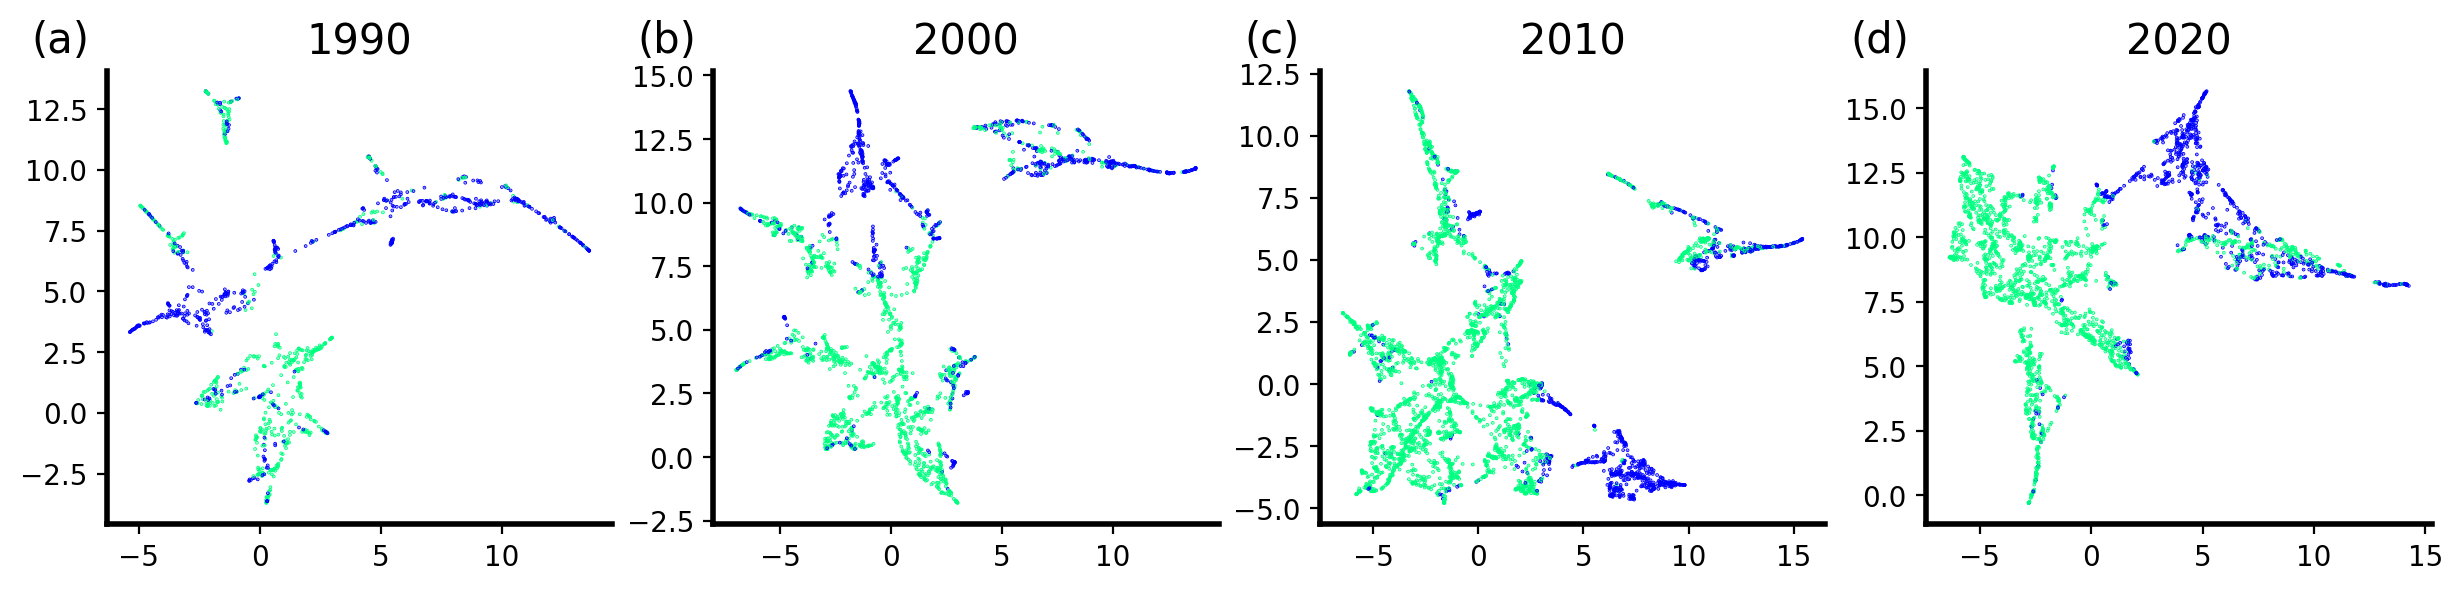

In [20]:
fig,ax=plt.subplots(1,4,dpi=200,figsize=(15,3))
import matplotlib
matplotlib.rcParams['axes.linewidth'] = 2
colormap='winter'
title_size=15
panel_lbl='abcd'
for i in range(4):
    ax[i].scatter([d[0] for d in mat_list[i]],[d[1] for d in mat_list[i]],s=0.1,c=y_list[i], cmap=colormap)
    ax[i].spines.right.set_visible(False)
    ax[i].spines.top.set_visible(False)
    ax[i].set_title(time_list[i],fontsize=title_size)
    ax[i].text(-0.15,1.02,'({})'.format(panel_lbl[i]),ha='left', va='bottom',transform=ax[i].transAxes,fontsize=title_size)
#ax[1].scatter([d[0] for d in matrix_2d_bsl],[d[1] for d in matrix_2d_bsl],s=0.1,c=y, cmap=colormap)
#ax[1].spines.right.set_visible(False)
#ax[1].spines.top.set_visible(False)
#ax[1].set_title('PCA')

"\nb=14\nax[2].set_facecolor('#f5f2ee')\nax[2].set_title('SNR Test',fontsize=title_size)\nax[2].bar([1,2,3],[23.8-b,19.0-b,28.2-b],color=['lightseagreen','lightgreen','olive'],width=0.6,bottom=b)\nax[2].spines['top'].set_color('#f5f2ee') \nax[2].spines['right'].set_color('#f5f2ee')\nb=2.5\nax[3].set_facecolor('#f5f2ee')\nax[3].set_title('mPESQ Test',fontsize=title_size)\nax[3].bar([1,2,3],[2.53-b,2.99-b,3.61-b],color=['lightseagreen','lightgreen','olive'],width=0.6,bottom=b)\nax[3].spines['top'].set_color('#f5f2ee') \nax[3].spines['right'].set_color('#f5f2ee')\n"

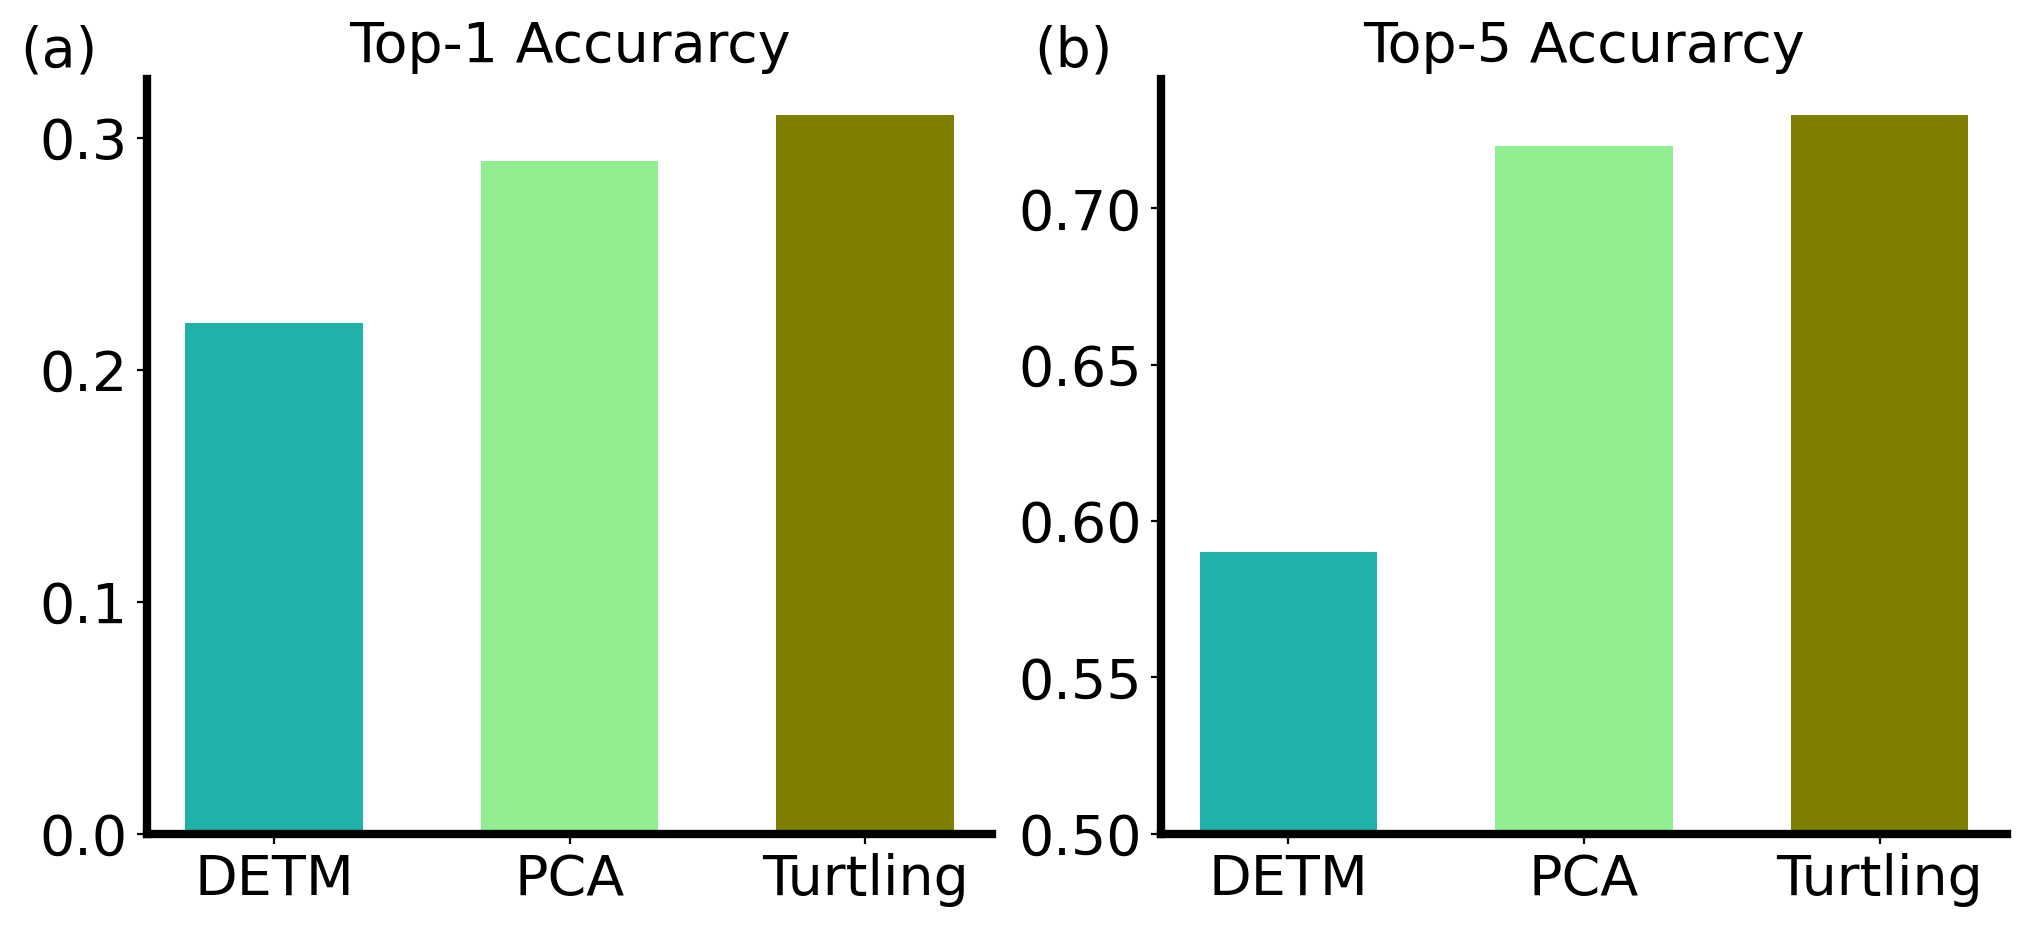

In [1]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
title_size=20
fig, ax=plt.subplots(1,2,figsize=(12,5),dpi=200)
b=0
#ax[0].set_facecolor('#f5f2ee')
ax[0].set_title('Top-1 Accurarcy',fontsize=title_size)
ax[0].bar([1,2,3],[0.22-b,0.29-b,0.31-b],color=['lightseagreen','lightgreen','olive'],width=0.6,bottom=b)
#ax[0].spines['top'].set_color('#f5f2ee') 
#ax[0].spines['right'].set_color('#f5f2ee')
ax[0].set_xticks([1,2,3])
ax[0].set_xticklabels(['DETM','PCA','Turtling'])
ax[0].text(-0.15,1,'(a)',ha='left', va='bottom',transform=ax[0].transAxes,fontsize=title_size)
b=0.5
#ax[1].set_facecolor('#f5f2ee')
ax[1].set_title('Top-5 Accurarcy',fontsize=title_size)
ax[1].bar([1,2,3],[0.59-b,0.72-b,0.73-b],color=['lightseagreen','lightgreen','olive'],width=0.6,bottom=b)
#ax[1].spines['top'].set_color('#f5f2ee') 
#ax[1].spines['right'].set_color('#f5f2ee')
ax[1].set_xticks([1,2,3])
ax[1].set_xticklabels(['DETM','PCA','Turtling'])
ax[1].text(-0.15,1,'(b)',ha='left', va='bottom',transform=ax[1].transAxes,fontsize=title_size)
for a in ax.flatten():
    a.spines.right.set_visible(False)
    a.spines.top.set_visible(False)
'''
b=14
ax[2].set_facecolor('#f5f2ee')
ax[2].set_title('SNR Test',fontsize=title_size)
ax[2].bar([1,2,3],[23.8-b,19.0-b,28.2-b],color=['lightseagreen','lightgreen','olive'],width=0.6,bottom=b)
ax[2].spines['top'].set_color('#f5f2ee') 
ax[2].spines['right'].set_color('#f5f2ee')
b=2.5
ax[3].set_facecolor('#f5f2ee')
ax[3].set_title('mPESQ Test',fontsize=title_size)
ax[3].bar([1,2,3],[2.53-b,2.99-b,3.61-b],color=['lightseagreen','lightgreen','olive'],width=0.6,bottom=b)
ax[3].spines['top'].set_color('#f5f2ee') 
ax[3].spines['right'].set_color('#f5f2ee')
'''